In [27]:
import os
import cv2
import pandas as pd
from PIL import Image

In [28]:
nose_cascade = cv2.CascadeClassifier('haarcascade_mcs_nose.xml')

In [29]:
faces = []
ages = []

for i in os.listdir('data/crop_part1/')[0:8000]:
    split = i.split('_')
    ages.append(int(split[0]))      

    img = cv2.imread('data/crop_part1/' + i)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    noses_rect = nose_cascade.detectMultiScale(gray, 1.3, 5)

    if len(noses_rect) > 0:
        faces.append(Image.fromarray(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)))
    else:
        faces.append(None) 

In [30]:
faces = pd.Series(faces, name='Faces')
ages = pd.Series(ages, name='Ages')

df = pd.concat([faces, ages], axis=1)

df

,Faces,Ages
0,<PIL.Image.Image image mode=RGB size=200x200 a...,9
1,<PIL.Image.Image image mode=RGB size=200x200 a...,1
2,<PIL.Image.Image image mode=RGB size=200x200 a...,16
3,<PIL.Image.Image image mode=RGB size=200x200 a...,1
4,<PIL.Image.Image image mode=RGB size=200x200 a...,26
...,...,...
7995,<PIL.Image.Image image mode=RGB size=200x200 a...,48
7996,<PIL.Image.Image image mode=RGB size=200x200 a...,65
7997,<PIL.Image.Image image mode=RGB size=200x200 a...,5
7998,<PIL.Image.Image image mode=RGB size=200x200 a...,35


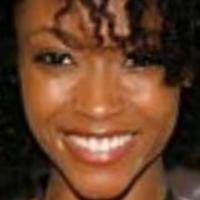

23


In [31]:
display(df['Faces'][900])
print(df['Ages'][900])

In [32]:
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical

processed_faces = []
labels = []

for i in range(len(df)):
    if df['Faces'][i] is not None:  # Filter out None values
        face_img = df['Faces'][i].resize((32, 32))  # Resize to 32x32
        face_array = img_to_array(face_img) / 255.0  # Normalize pixel values
        processed_faces.append(face_array)
        labels.append(df['Ages'][i])  

processed_faces = np.array(processed_faces)
labels = np.array(labels)

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(processed_faces, labels, test_size=0.2, random_state=42)

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

model = Sequential([
    Conv2D(32, (5, 5), activation='relu', input_shape=(32, 32, 3)),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(64, (5, 5), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1)  # For age regression
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])  # MSE loss for regression

/opt/anaconda3/envs/bootcamp3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [35]:
history = model.fit(X_train, y_train, epochs=200, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 804.8715 - mae: 22.7984 - val_loss: 544.0458 - val_mae: 19.5651
Epoch 2/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 551.7699 - mae: 19.0604 - val_loss: 335.4460 - val_mae: 14.5589
Epoch 3/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 352.5872 - mae: 14.3170 - val_loss: 291.7640 - val_mae: 13.4417
Epoch 4/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 331.5842 - mae: 13.5982 - val_loss: 262.9828 - val_mae: 12.3128
Epoch 5/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 312.3484 - mae: 13.0722 - val_loss: 245.8141 - val_mae: 11.5090
Epoch 6/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 282.6523 - mae: 12.3590 - val_loss: 258.7260 - val_mae: 11.0647
Epoch 7/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 266.4992 - mae: 11.8205 - val_loss: 216.8241 - val_mae: 10.5084
Epoch 8/10
190/190 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 251.3758 - mae: 11.4950 - val_loss: 205.7212 - val_mae: 10.1070
Epoch 9/

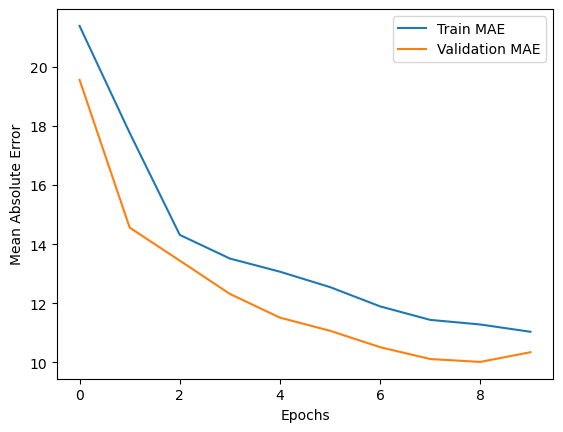

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 219.3488 - mae: 10.0223
Test MAE: 10.33869457244873


In [36]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

# Model Evaluation
test_loss, test_mae = model.evaluate(X_test, y_test)
print(f"Test MAE: {test_mae}")

In [37]:
test_loss, test_mae = model.evaluate(X_test, y_test)
model_results_1 = test_mae
history_1 = history
model_1 = model
df_1 = df

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 219.3488 - mae: 10.0223


In [42]:
face_image = df['Faces'][900]  # Get the nose image
display(face_image)

if face_image is not None:
    face_image = face_image.resize((32, 32))
    face_array = img_to_array(face_image) / 255.0
    prepared_image = np.expand_dims(face_array, axis=0)
    
    predicted_face_age = model.predict(prepared_image)
    
    print(f"Age: {predicted_face_age[0][0]:.2f}")
else:
    print("No nose image found")